In [6]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!C:\GnuWin32\bin\wget.exe --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [116]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [117]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [118]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [119]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [120]:
# Set up some global values here
content_path = '/tmp/nst/photo.jpg'
style_path = '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

In [121]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
    img = kp_image.img_to_array(img)
  
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

In [122]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

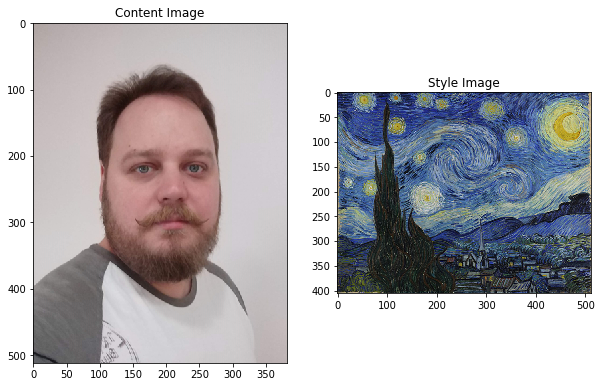

In [123]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [124]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [125]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                                 "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x  

In [126]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [127]:
def get_model():
    """ Creates our model with access to intermediate layers. 
  
    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 
  
    Returns:
      returns a keras model that takes image inputs and outputs the style and 
        content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

In [128]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [129]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [130]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 
  
    Arguments:
      model: The model that we are using.
      content_path: The path to the content image.
      style_path: The path to the style image
    
    Returns:
      returns the style features and the content features. 
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
  
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
  
  
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [265]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

In [131]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.
  
    Arguments:
      model: The model that will give us access to the intermediate layers
      loss_weights: The weights of each contribution of each loss function. 
        (style weight, content weight, and total variation weight)
      init_image: Our initial base image. This image is what we are updating with 
        our optimization process. We apply the gradients wrt the loss we are 
        calculating to this image.
      gram_style_features: Precomputed gram matrices corresponding to the 
        defined style layers of interest.
      content_features: Precomputed outputs from defined content layers of 
        interest.
      
    Returns:
      returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights
  
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [132]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [301]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight = 1e-2, learning_rate = 2): 
    display_num = 100
    # We don't need to (or want to) train any layers of our model, so we set their trainability
    # to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

    # For displaying intermediate images 
    iter_count = 1
    g = 1
    # Store our best result
    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
          'model': model,
          'loss_weights': loss_weights,
          'init_image': init_image,
          'gram_style_features': gram_style_features,
          'content_features': content_features
    }
    
    # For displaying
    plt.figure(figsize=(15, 15))
    num_rows = max((num_iterations / display_num) // 5, 1)
    print (num_rows)
    start_time = time.time()
    global_start = time.time()
    print(global_start)
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        # grads, _ = tf.clip_by_global_norm(grads, 5.0)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_num == 0:
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            start_time = time.time()
      
        # Display intermediate images
        #if (iter_count > num_rows * 5): continue 
        if iter_count % 100 == 0:
            
            plt.subplot(num_rows, 5, g)
        # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            plt.imshow(plot_img)
            plt.title('Iteration {}'.format(i + 1))
            g+=1
            

        iter_count += 1
        
    print('Total time: {:.4f}s'.format(time.time() - global_start))
      
    return best_img, best_loss 

20.0
1545695695.5790303
Iteration: 0
Total loss: 1.1632e+12, style loss: 1.1632e+12, content loss: 0.0000e+00, time: 0.1257s
Iteration: 100
Total loss: 6.6615e+09, style loss: 6.6615e+09, content loss: 2.4851e+04, time: 11.6175s
Iteration: 200
Total loss: 3.3348e+09, style loss: 3.3348e+09, content loss: 2.5369e+04, time: 11.5900s
Iteration: 300
Total loss: 2.3651e+09, style loss: 2.3651e+09, content loss: 2.5900e+04, time: 11.5920s
Iteration: 400
Total loss: 1.8892e+09, style loss: 1.8891e+09, content loss: 2.6395e+04, time: 11.5910s
Iteration: 500
Total loss: 1.5973e+09, style loss: 1.5973e+09, content loss: 2.6842e+04, time: 11.5987s
Iteration: 600
Total loss: 1.3975e+09, style loss: 1.3975e+09, content loss: 2.7306e+04, time: 11.5880s
Iteration: 700
Total loss: 1.2487e+09, style loss: 1.2487e+09, content loss: 2.7748e+04, time: 11.5990s
Iteration: 800
Total loss: 1.1300e+09, style loss: 1.1300e+09, content loss: 2.8122e+04, time: 11.5900s
Iteration: 900
Total loss: 1.0330e+09, styl

Iteration: 7800
Total loss: 1.5259e+08, style loss: 1.5256e+08, content loss: 3.1426e+04, time: 11.3795s
Iteration: 7900
Total loss: 1.8950e+08, style loss: 1.8947e+08, content loss: 3.1343e+04, time: 11.2461s
Iteration: 8000
Total loss: 1.5112e+08, style loss: 1.5109e+08, content loss: 3.1420e+04, time: 11.1462s
Iteration: 8100
Total loss: 2.2691e+08, style loss: 2.2687e+08, content loss: 3.1360e+04, time: 11.2020s
Iteration: 8200
Total loss: 1.4848e+08, style loss: 1.4845e+08, content loss: 3.1435e+04, time: 11.3153s
Iteration: 8300
Total loss: 1.4430e+08, style loss: 1.4427e+08, content loss: 3.1451e+04, time: 11.2579s
Iteration: 8400
Total loss: 9.6198e+08, style loss: 9.6195e+08, content loss: 3.0703e+04, time: 11.2860s
Iteration: 8500
Total loss: 1.5387e+08, style loss: 1.5384e+08, content loss: 3.1378e+04, time: 11.1972s
Iteration: 8600
Total loss: 1.4298e+08, style loss: 1.4295e+08, content loss: 3.1429e+04, time: 11.1442s
Iteration: 8700
Total loss: 1.4000e+08, style loss: 1.3

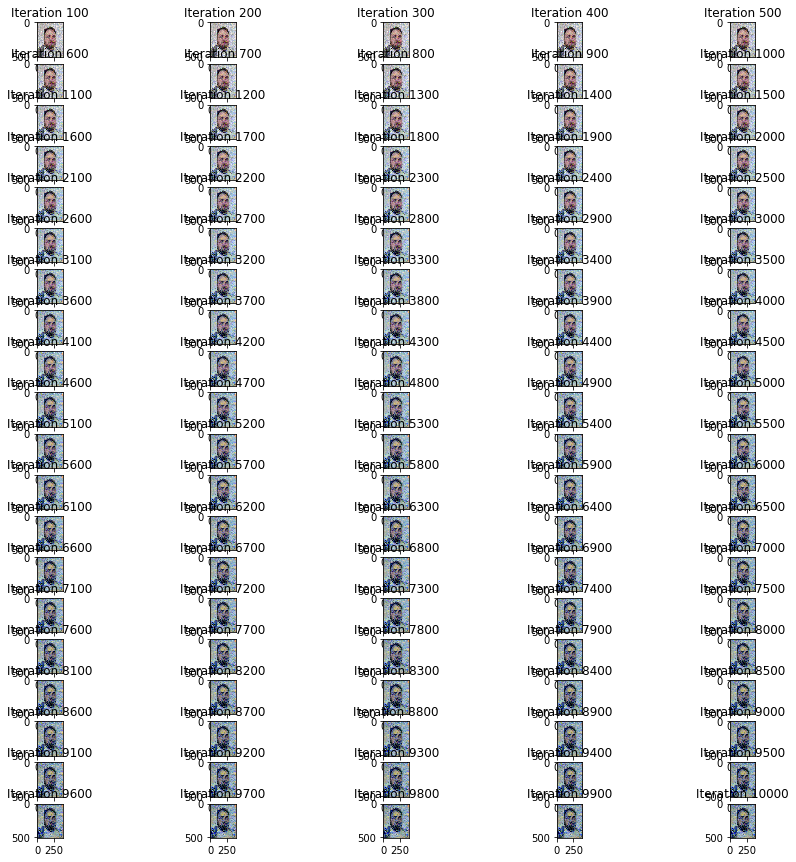

In [302]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=10000, content_weight=10, style_weight=40, learning_rate = 2)

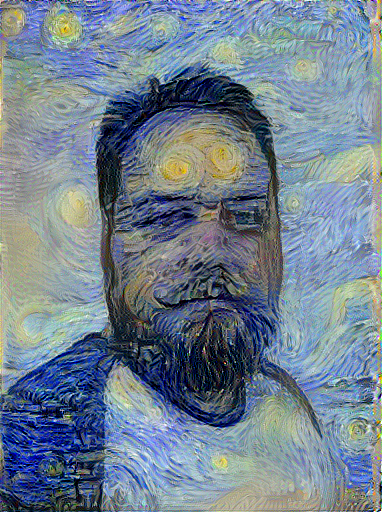

In [303]:
Image.fromarray(best)

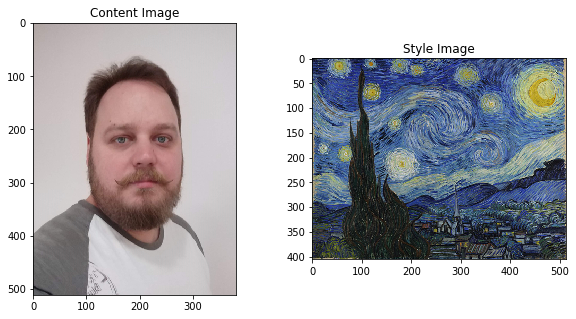

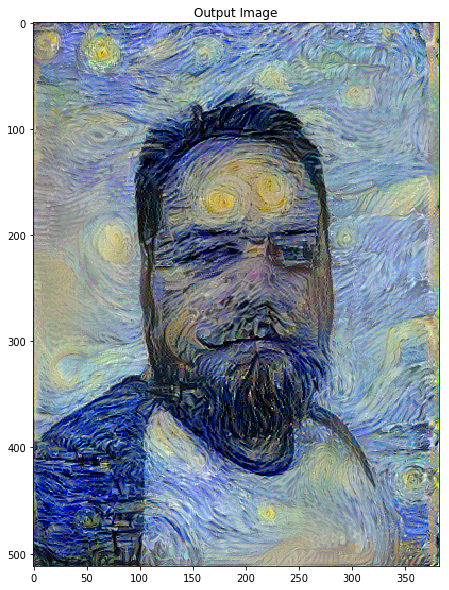

In [304]:
show_results(best, content_path, style_path)

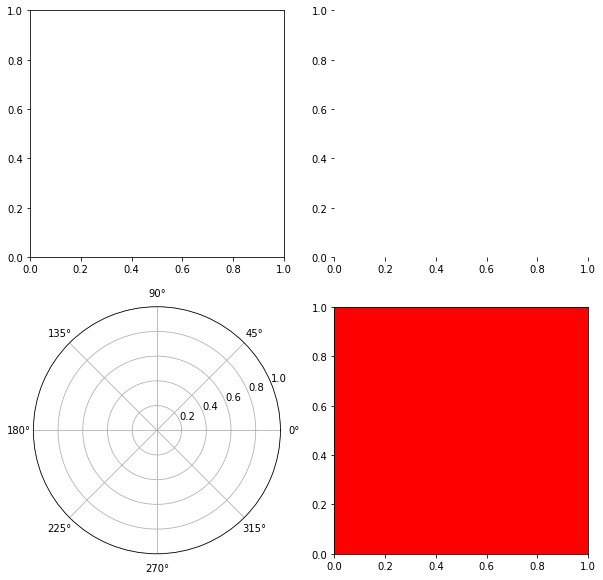

In [295]:
# equivalent but more general
ax1=plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2=plt.subplot(222, frameon=False)

# add a polar subplot
plt.subplot(223, projection='polar')

# add a red subplot that shares the x-axis with ax1
plt.subplot(224, sharex=ax1, facecolor='red')
